In [184]:
from eval import *

import pandas as pd
import torch
import torchtext; torchtext.disable_torchtext_deprecation_warning()
from preprocessing import create_split
from pmf import PMF
from lr import LogReg
import pickle

data = pd.read_csv('data/men_data.csv')
REPLACEMENT_LEVELS = [500,1000]
SEED = 42

train, test = create_split(data, SEED)

# ------

In [185]:
import os
from glob import glob 

lr_files = glob('models/lr/model_*_fold_*.pkl') 
pmf_files = glob('models/pmf/model_*_*_fold_*.pth')
pmf_files

['models/pmf/model_1_100_fold_2.pth',
 'models/pmf/model_3_1000_fold_3.pth',
 'models/pmf/model_3_1000_fold_2.pth',
 'models/pmf/model_1_100_fold_3.pth',
 'models/pmf/model_1_100_fold_1.pth',
 'models/pmf/model_4_1000_fold_4.pth',
 'models/pmf/model_4_1000_fold_5.pth',
 'models/pmf/model_3_1000_fold_1.pth',
 'models/pmf/model_1_100_fold_4.pth',
 'models/pmf/model_4_1000_fold_1.pth',
 'models/pmf/model_3_1000_fold_5.pth',
 'models/pmf/model_3_1000_fold_4.pth',
 'models/pmf/model_1_100_fold_5.pth',
 'models/pmf/model_4_1000_fold_2.pth',
 'models/pmf/model_4_1000_fold_3.pth',
 'models/pmf/model_2_100_fold_3.pth',
 'models/pmf/model_2_1000_fold_5.pth',
 'models/pmf/model_4_100_fold_4.pth',
 'models/pmf/model_1_50_fold_4.pth',
 'models/pmf/model_2_50_fold_1.pth',
 'models/pmf/model_1_50_fold_5.pth',
 'models/pmf/model_4_100_fold_5.pth',
 'models/pmf/model_2_1000_fold_4.pth',
 'models/pmf/model_2_100_fold_2.pth',
 'models/pmf/model_2_50_fold_2.pth',
 'models/pmf/model_3_100_fold_4.pth',
 'mo

In [186]:
models=[]

In [187]:
for file in lr_files: 
    with open(file, 'rb') as f:
        lr_model = pickle.load(f)
        val_ind = lr_model['val_indices'] 
        # get the replacemnet level and fold num from the naming convention
        file_name = os.path.basename(file)
        file_root, _ = os.path.splitext(file_name)
        replacement_level, fold = map(int, file_root.split('_')[1::2]) # basically takes the 2nd and 4th elements of the split string (the replacement level and fold number) and turns it to an int
        
        train_df = data.iloc[~val_ind] # not the validation set
        test_df = data.iloc[val_ind] # the validation set
        model = lr_model['model']
        train_res = analyze_model(model, train_df)
        test_res = analyze_model(model, test_df)
        # for dataset, results in [('train', train_res), ('test', test_res)]:
        #     models.append({
        #         'model_type': 'lr',
        #         'replacement_level': replacement_level,
        #         'fold': fold,
        #         'num_factors': None,
        #         **results # unpack the results dict 
        #     })

        models.append({
            'model_type': 'lr',
            'replacement_level': replacement_level,
            'k_fold': fold,
            'num_factors': np.nan,
            'dataset': 'train',
            **train_res # unpack the results dict 
        })
        models.append({
            'model_type': 'lr',
            'replacement_level': replacement_level,
            'k_fold': fold,
            'num_factors': np.nan,
            'dataset': 'test',
            **test_res
        })


In [188]:
for file in pmf_files:
    pmf_model = torch.load(file)
    file_name = os.path.basename(file)
    file_root, _ = os.path.splitext(file_name)
    split = file_root.split('_')
    num_factors, replacement_level, fold = map(int, [split[1], split[2], split[4]])

    model = PMF(data, pmf_model['climber_vocab'], pmf_model['problem_vocab'], replacement_level, num_factors)
    
    model.load_state_dict(pmf_model['model_state_dict']) # load the model that was saved
    val_ind = pmf_model['val_indices'] 

    train_df = data.iloc[~val_ind]
    test_df = data.iloc[val_ind]

    train_res = analyze_model(model, train_df)
    test_res = analyze_model(model, test_df)

    # for dataset, results in [('train', train_res), ('test', test_res)]:
    #     models.append({
    #         'model_type': 'pmf',
    #         'replacement_level': replacement_level,
    #         'fold': fold,
    #         'num_factors': int(num_factors),
    #         **results
    #     })
    models.append({
        'model_type': 'pmf',
        'replacement_level': replacement_level,
        'k_fold': fold,
        'num_factors': int(num_factors),
        'dataset': 'train',
        **train_res # unpack the results dict 
    })
    models.append({
        'model_type': 'pmf',
        'replacement_level': replacement_level,
        'k_fold': fold,
        'num_factors': int(num_factors),
        'dataset': 'test',
        **test_res
    })

In [189]:
metrics = pd.DataFrame(models)
metrics

,model_type,replacement_level,k_fold,num_factors,dataset,Accuracy,Log Loss,Brier Score,F1 Score,ROC Score
0,lr,250,3,NaN,train,0.621579,0.637965,0.224029,0.613124,0.652143
1,lr,250,3,NaN,test,0.638512,0.645395,0.227009,0.620870,0.659114
2,lr,250,2,NaN,train,0.619766,0.639630,0.224729,0.612390,0.649597
3,lr,250,2,NaN,test,0.625541,0.649715,0.229136,0.606971,0.647634
4,lr,500,5,NaN,train,0.550961,0.652244,0.230959,0.444011,0.600009
...,...,...,...,...,...,...,...,...,...,...
245,pmf,500,4,1.0,test,0.746210,0.520687,0.169388,0.756563,0.827915
246,pmf,250,3,1.0,train,0.741681,0.524034,0.169455,0.775291,0.822434
247,pmf,250,3,1.0,test,0.735184,0.530485,0.173956,0.743533,0.818912
248,pmf,250,2,1.0,train,0.738614,0.536979,0.170504,0.771578,0.820307


In [196]:
metrics.loc[metrics['F1 Score'].idxmax()]
metrics.query('replacement_level == 50 and k_fold == 4 and num_factors == 4.0')


,model_type,replacement_level,k_fold,num_factors,dataset,Accuracy,Log Loss,Brier Score,F1 Score,ROC Score
180,pmf,50,4,4.0,train,0.831791,0.820167,0.123941,0.852811,0.899687
181,pmf,50,4,4.0,test,0.831857,0.810731,0.122998,0.841910,0.902398


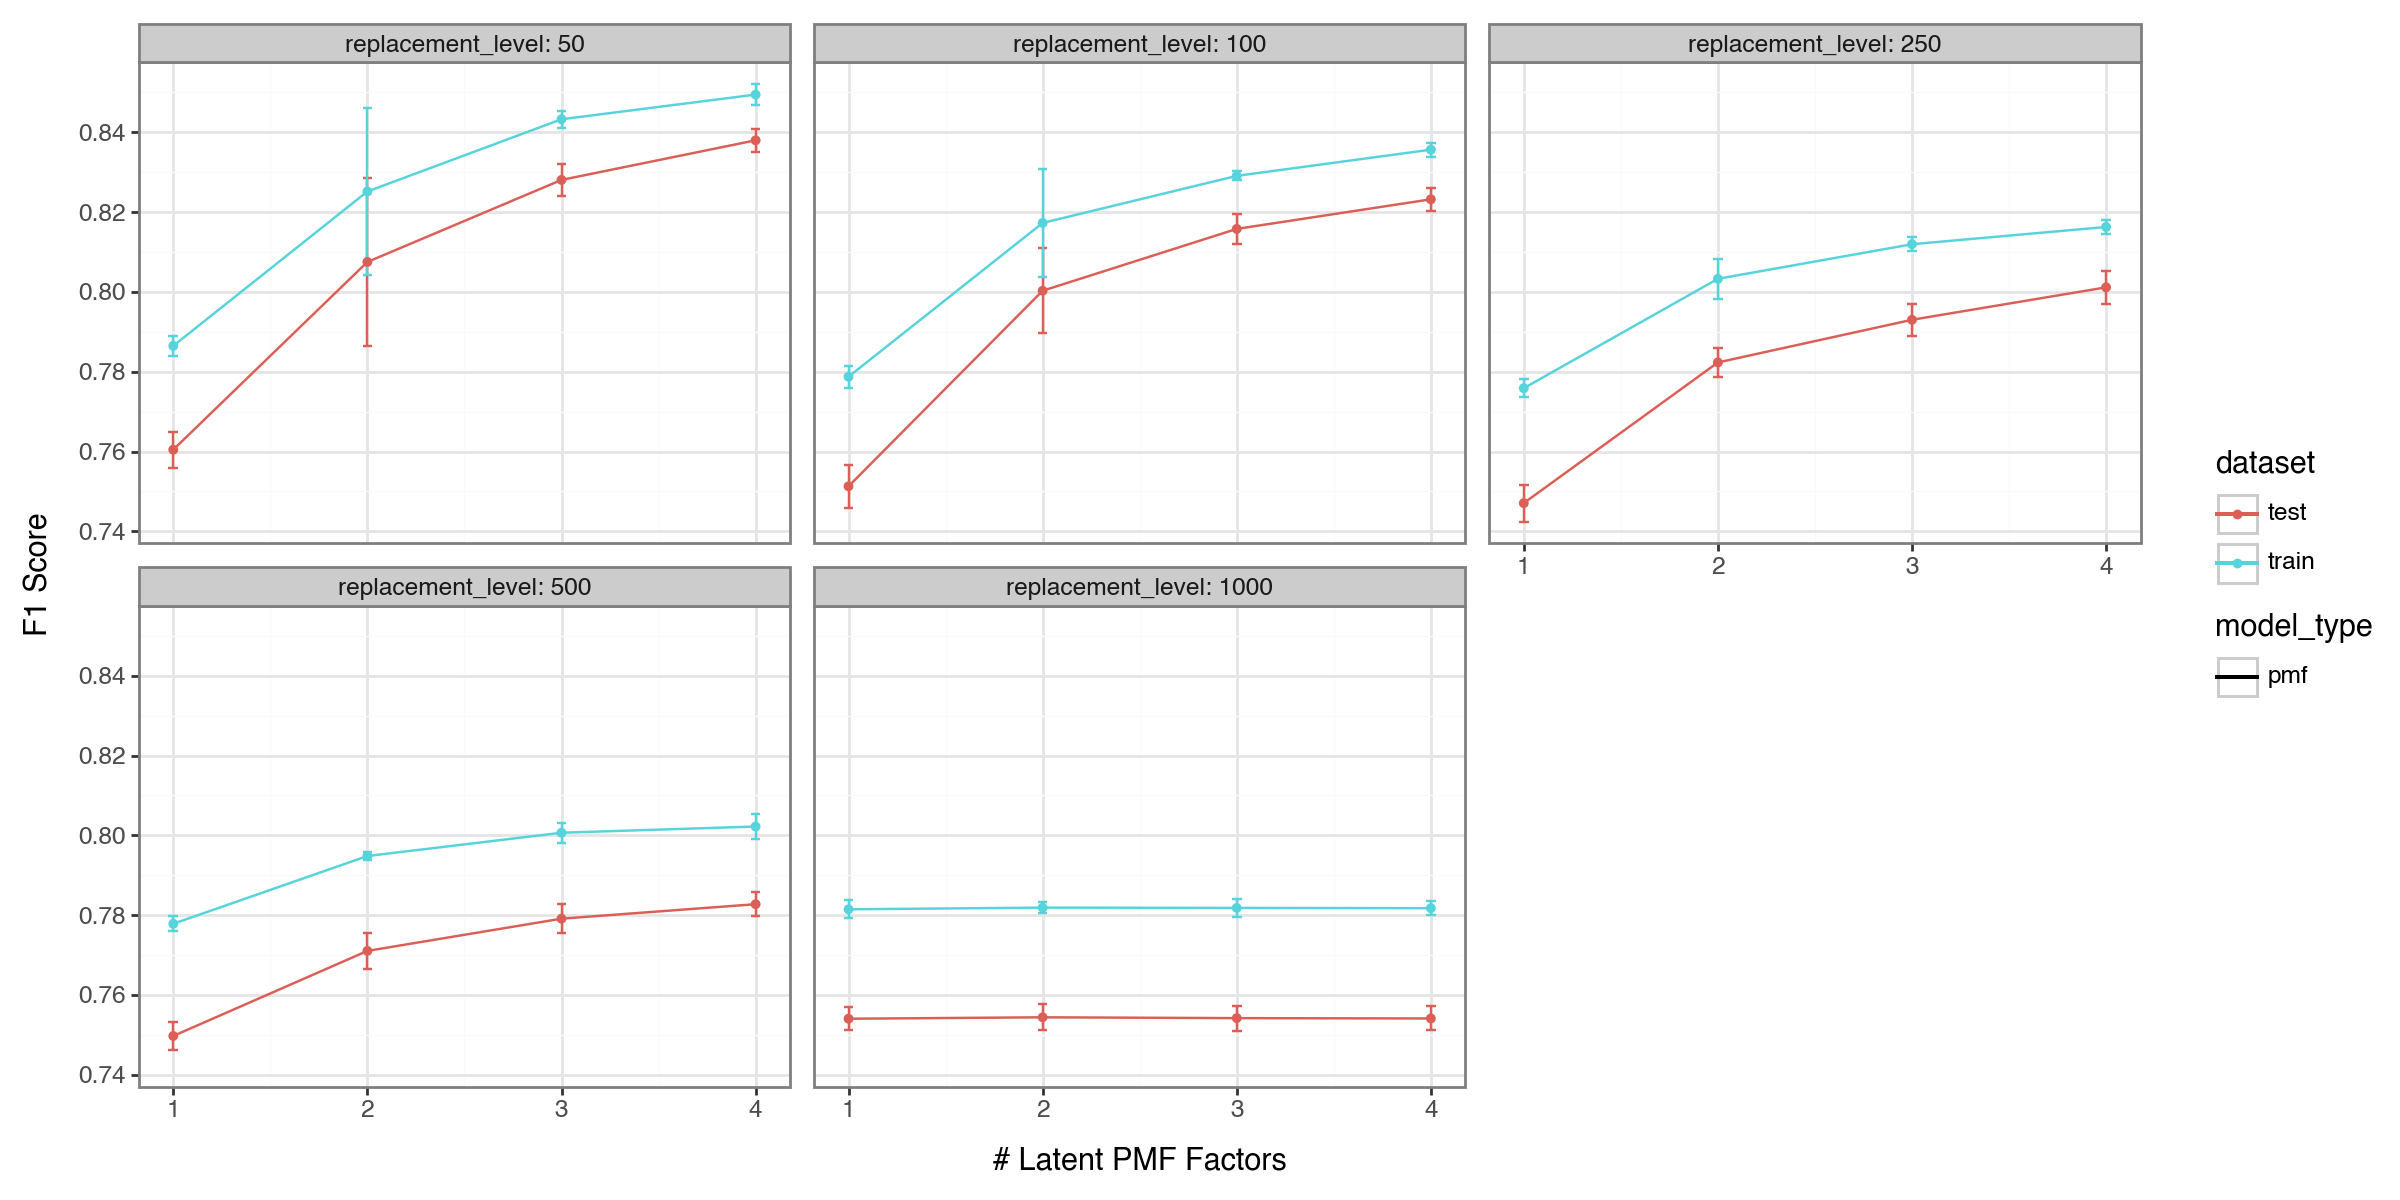

In [197]:
import plotnine
from plotnine import *

plot_data = (
    metrics
    .groupby(['model_type', 'replacement_level', 'num_factors', 'dataset'])
    ['F1 Score'].agg(['mean', 'std', 'size'])
    .reset_index()
    .assign(
        se = lambda d: d['std'] / d['size'].apply(np.sqrt),
        mean_err_min = lambda d: d['mean'] - 1.96 * d.se,
        mean_err_max = lambda d: d['mean'] + 1.96 * d.se
    )
)

plotnine.options.figure_size = (12, 6)
p = (
  plot_data
  .pipe(ggplot, aes(x = "num_factors", y = "mean", color = "dataset", linetype = "model_type")) +
  # Add horizontal lines for logistic regression
  # geom_hline(aes(yintercept = "mean", color = "dataset"), data = plot_data.query("model_type == 'lr'")) +
  # Add lines and points for PMF
  geom_line() +
  geom_errorbar(aes(ymin = "mean_err_min", ymax = "mean_err_max"), width = 0.05) +
  geom_point(size = 1, data = plot_data.query("model_type == 'pmf'")) +
  facet_wrap("~ replacement_level", labeller="label_both") +
  labs(x = "# Latent PMF Factors", y = "F1 Score") +
  theme_bw()
)

p